# Predict INTC index 2
## Follow this tutorial https://habr.com/ru/post/495884/

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import yfinance as yf
import pandas_datareader.data as pdr
import time
yf.pdr_override()

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
csv_path = 'stock_prices.csv'

In [5]:
all_data = pdr.get_data_yahoo("INTC", period='2y', interval="60m")
all_data.to_csv(csv_path)

[*********************100%***********************]  1 of 1 completed


In [18]:
column = 'Adj Close'

df = pd.read_csv(csv_path)
date_time = pd.to_datetime(df['Datetime'])
df

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2018-10-24 09:30:00-04:00,44.200001,44.340000,43.840000,43.919998,43.919998,4274310
1,2018-10-24 10:30:00-04:00,43.869999,43.945000,43.450001,43.459999,43.459999,3412679
2,2018-10-24 11:30:00-04:00,43.439999,43.869999,43.160000,43.660000,43.660000,3636549
3,2018-10-24 12:30:00-04:00,43.660000,43.680000,43.310001,43.450001,43.450001,2515495
4,2018-10-24 13:30:00-04:00,43.470001,43.735001,43.365002,43.720001,43.720001,3392976
...,...,...,...,...,...,...,...
3507,2020-10-23 11:30:00-04:00,47.895000,48.130001,47.790001,48.130001,48.130001,9467008
3508,2020-10-23 12:30:00-04:00,48.130001,48.270000,47.910000,48.055000,48.055000,7971636
3509,2020-10-23 13:30:00-04:00,48.049999,48.119999,47.974998,48.060001,48.060001,5088307
3510,2020-10-23 14:30:00-04:00,48.060001,48.090000,47.930000,48.013699,48.013699,6310866


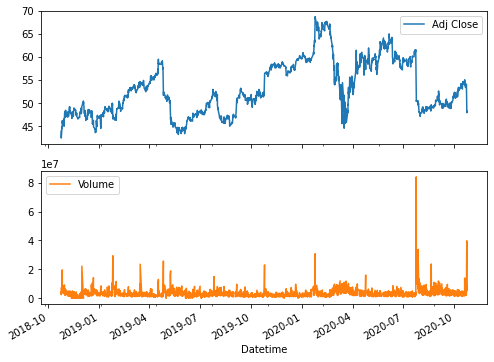

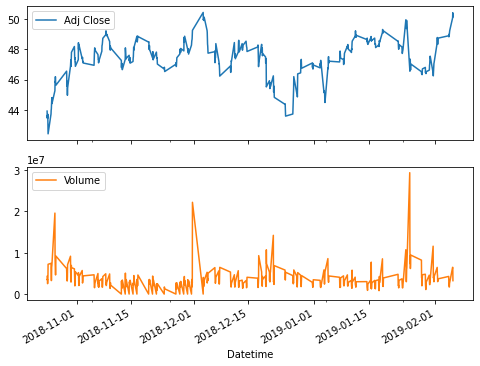

In [19]:
plot_cols = ['Adj Close', 'Volume']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,3512.0,5.314366e+01,5.726578e+00,43.080002,4.832000e+01,5.184250e+01,5.809500e+01,6.870000e+01
High,3512.0,5.336987e+01,5.735627e+00,43.118401,4.856000e+01,5.208000e+01,5.832000e+01,6.929000e+01
Low,3512.0,5.291766e+01,5.716872e+00,42.360001,4.812983e+01,5.161000e+01,5.785625e+01,6.849000e+01
Close,3512.0,5.314835e+01,5.727142e+00,42.419998,4.833000e+01,5.183250e+01,5.812125e+01,6.871000e+01
Adj Close,3512.0,5.314835e+01,5.727142e+00,42.419998,4.833000e+01,5.183250e+01,5.812125e+01,6.871000e+01
Volume,3512.0,3.062688e+06,2.766089e+06,0.000000,1.706648e+06,2.453536e+06,3.634933e+06,8.395446e+07


In [74]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

def baseline(history):
  """для заданного входного вектора метод базового решения «просматривает» всю историю и прогнозирует следующее значение как среднее из последних n наблюдений."""
  return np.mean(history)

TRAIN_SPLIT = 1500
tf.random.set_seed(13)

TARGET_COLUMN = 'Adj Close'

### Часть 1. Прогнозирование на основе одномерного временного ряда


In [75]:
uni_data = df[TARGET_COLUMN]
uni_data.index = df['Datetime']
uni_data.head()

Datetime
2018-10-24 09:30:00-04:00    43.919998
2018-10-24 10:30:00-04:00    43.459999
2018-10-24 11:30:00-04:00    43.660000
2018-10-24 12:30:00-04:00    43.450001
2018-10-24 13:30:00-04:00    43.720001
Name: Adj Close, dtype: float64

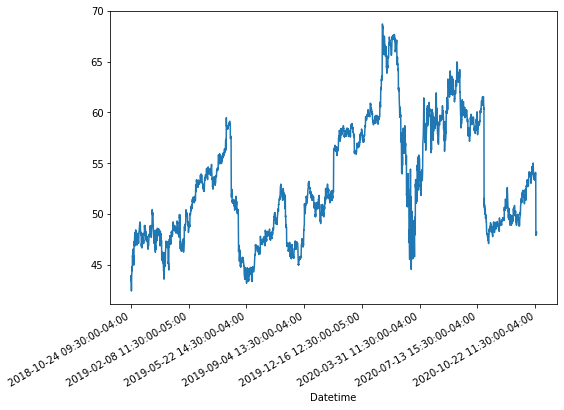

In [76]:
uni_data.plot(subplots=True)
uni_data = uni_data.values

Single window of past history
[[-1.59150816]
 [-1.66846884]
 [-1.63500748]
 [-1.67014162]
 [-1.62496888]
 [-1.73038854]
 [-1.84246741]
 [-1.6232961 ]
 [-1.58063285]
 [-1.56808476]
 [-1.51538355]
 [-1.4635184 ]
 [-1.44260513]
 [-1.50785507]
 [-1.36564445]
 [-1.26358759]
 [-1.27362619]
 [-1.21088637]
 [-1.26693379]
 [-1.27948188]]

 Target Adj Close to predict
-1.3054141279820475


<module 'matplotlib.pyplot' from 'C:\\Users\\User\\Documents\\loyaltyplant\\twitter_bot\\lib\\site-packages\\matplotlib\\pyplot.py'>

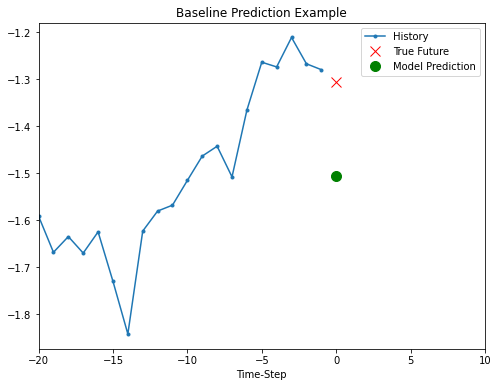

In [32]:

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print ('Single window of past history')
print (x_train_uni[0])
print (f'\n Target {TARGET_COLUMN} to predict')
print (y_train_uni[0])
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

#### Рекуррентная нейронная сеть

Рекуррентная нейронная сеть (РНС) — это тип ИНС, который хорошо подходит для решения задач, связанных с временными рядами. РНС шаг за шагом обрабатывает временную последовательность данных, перебирая её элементы и сохраняя внутреннее состояние, полученное при обработке предыдущих элементов.

In [77]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.3369 - val_loss: 0.1030
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1023 - val_loss: 0.0731
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0733 - val_loss: 0.0609
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0637 - val_loss: 0.0527
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0579 - val_loss: 0.0489
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0543 - val_loss: 0.0460
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0519 - val_loss: 0.0435
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0501 - val_loss: 0.0423
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0488 - val_loss: 0.0416
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0481 - val_loss: 0.0417

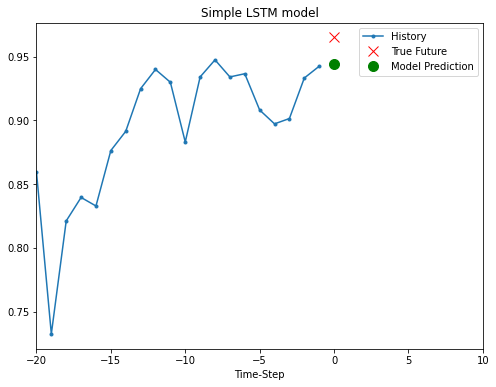

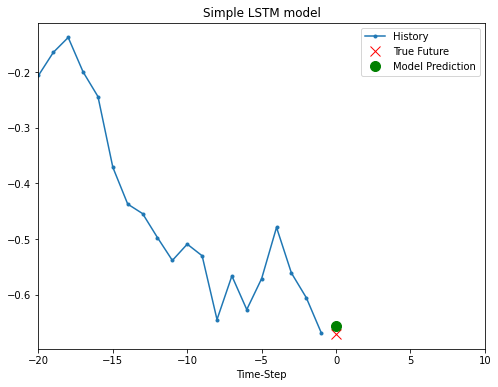

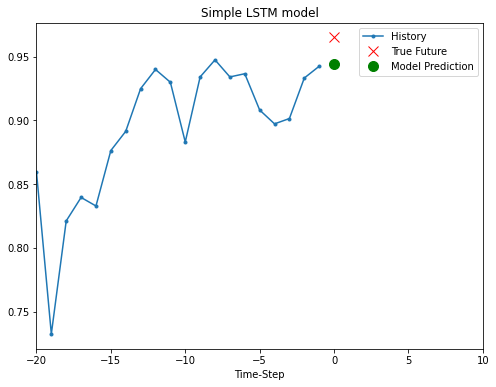

In [78]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

### Часть 2: Прогнозирование на основе многомерного временного ряда

In [79]:
features_considered = ['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume']
features = df[features_considered]
features.index = df['Datetime']
features.head()

,Open,Close,High,Low,Adj Close,Volume
Datetime,,,,,,
2018-10-24 09:30:00-04:00,44.200001,43.919998,44.340000,43.840000,43.919998,4274310
2018-10-24 10:30:00-04:00,43.869999,43.459999,43.945000,43.450001,43.459999,3412679
2018-10-24 11:30:00-04:00,43.439999,43.660000,43.869999,43.160000,43.660000,3636549
2018-10-24 12:30:00-04:00,43.660000,43.450001,43.680000,43.310001,43.450001,2515495
2018-10-24 13:30:00-04:00,43.470001,43.720001,43.735001,43.365002,43.720001,3392976


array([<AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>,
       <AxesSubplot:xlabel='Datetime'>, <AxesSubplot:xlabel='Datetime'>],
      dtype=object)

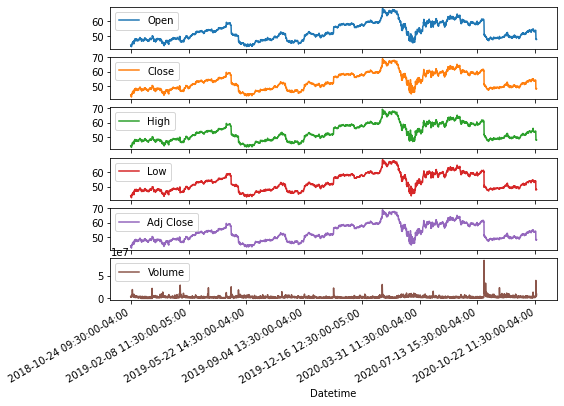

In [80]:
features.plot(subplots=True)

In [81]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis = 0)
data_std = dataset[:TRAIN_SPLIT].std(axis = 0)
dataset = (dataset-data_mean) / data_std

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

dataset[:, 1]

array([-1.49413963, -1.62574357, -1.56852413, ..., -0.30970083,
       -0.32294788, -0.26964755])

In [85]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

print ('Single window of past history : {}'.format(x_train_single[0].shape))
for x, y in val_data_single.take(1):
  print(f'predict shape: {single_step_model.predict(x).shape}')

Single window of past history : (120, 6)
predict shape: (256, 1)


In [86]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 16s 79ms/step - loss: 0.4780 - val_loss: 2.4607
Epoch 2/10
200/200 [==============================] - 16s 82ms/step - loss: 0.1977 - val_loss: 2.3913
Epoch 3/10
200/200 [==============================] - 16s 81ms/step - loss: 0.1618 - val_loss: 2.4586
Epoch 4/10
200/200 [==============================] - 16s 82ms/step - loss: 0.1461 - val_loss: 2.5619
Epoch 5/10
200/200 [==============================] - 16s 82ms/step - loss: 0.1373 - val_loss: 2.6060
Epoch 6/10
200/200 [==============================] - 16s 82ms/step - loss: 0.1289 - val_loss: 2.3791
Epoch 7/10
200/200 [==============================] - 16s 80ms/step - loss: 0.1262 - val_loss: 2.2828
Epoch 8/10
200/200 [==============================] - 17s 84ms/step - loss: 0.1172 - val_loss: 2.4316
Epoch 9/10
200/200 [==============================] - 16s 79ms/step - loss: 0.1154 - val_loss: 2.4589
Epoch 10/10
200/200 [==============================] - 16s 78ms/step - loss: 0.108

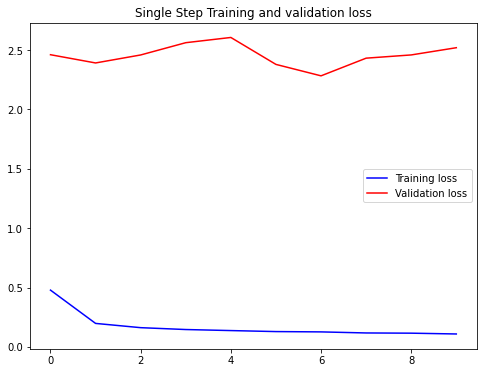

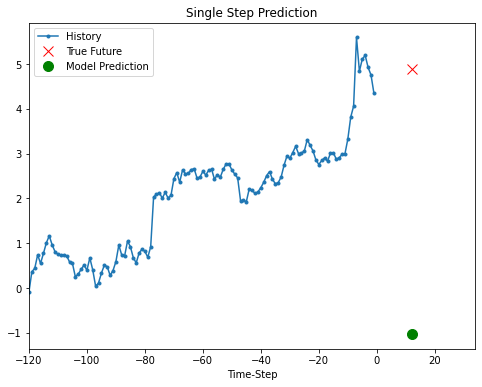

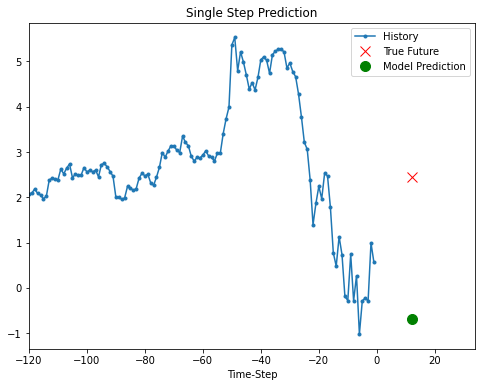

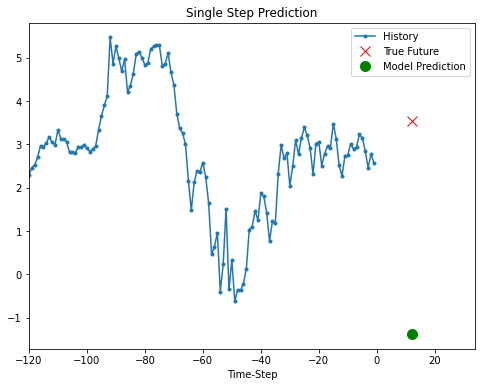

In [87]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()